In [1]:
import os
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import folium
import matplotlib as plt
from prophet import Prophet

In [2]:
AGGREGATED_REGIONS = [
    "CAL",
    "CAR",
    "CENT",
    "FLA",
    "MIDA",
    "MIDW",
    "NE",
    "NW",
    "NY",
    "SE",
    "SW",
    "TEN",
    "TEX",
    "US48",
]

EIA_API_KEY = os.getenv("EIA_API_KEY")
if not EIA_API_KEY:
    raise EnvironmentError("Please set your EIA_API_KEY environment variable.")

url = "https://api.eia.gov/v2/electricity/rto/region-data/data/"
params = {
    "api_key": EIA_API_KEY,
    "frequency": "hourly",
    "data[0]": "value",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
}
params["facets[respondent][]"] = AGGREGATED_REGIONS

try:
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()["response"]["data"]
    df = pd.DataFrame(data)
    df.to_csv("eia_hourly_cached.csv", index=False)
except Exception as exc:
    cache_path = "eia_hourly_cached.csv"
    if not os.path.exists(cache_path):
        raise RuntimeError("Failed to download data and no cached file was found.") from exc
    print(f"⚠️ Using cached data because API request failed: {exc}")
    df = pd.read_csv(cache_path)

df["region"] = df["respondent"]
df.head()




,period,respondent,respondent-name,type,type-name,value,value-units,region
0,2025-11-15T08,CAL,California,DF,Day-ahead demand forecast,26651,megawatthours,CAL
1,2025-11-15T08,NW,Northwest,DF,Day-ahead demand forecast,21807,megawatthours,NW
2,2025-11-15T08,US48,United States Lower 48,DF,Day-ahead demand forecast,48458,megawatthours,US48
3,2025-11-15T07,CAL,California,DF,Day-ahead demand forecast,28241,megawatthours,CAL
4,2025-11-15T07,NW,Northwest,DF,Day-ahead demand forecast,36392,megawatthours,NW


In [3]:
df = df.copy()
df["region"] = df["respondent"]
df["datetime"] = pd.to_datetime(df["period"])
df["demand_MW"] = pd.to_numeric(df["value"], errors="coerce")

latest_idx = df.groupby("region")["datetime"].idxmax()
latest_df = df.loc[latest_idx].copy()
usage = latest_df[["region", "demand_MW", "datetime"]]
latest_time = usage["datetime"].max() # <--Grab the latest data


In [4]:
# ======================================================
# 2️⃣ Region → state mapping (unchanged)
# ======================================================
region_to_states = {
    "CAL": ["California"],
    "CAR": ["North Carolina", "South Carolina"],
    "CENT": ["Arkansas", "Kansas", "Louisiana", "Missouri", "Nebraska", "Oklahoma"],
    "FLA": ["Florida"],
    "MIDA": ["Delaware", "District of Columbia", "Maryland", "New Jersey", "Pennsylvania", "Virginia", "West Virginia"],
    "MIDW": ["Illinois", "Indiana", "Iowa", "Kentucky", "Michigan", "Minnesota", "North Dakota", "Ohio", "South Dakota", "Wisconsin"],
    "NE": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont"],
    "NY": ["New York"],
    "NW": ["Idaho", "Montana", "Oregon", "Washington", "Wyoming"],
    "SE": ["Alabama", "Georgia", "Mississippi"],
    "SW": ["Arizona", "Colorado", "New Mexico", "Nevada", "Utah"],
    "TEN": ["Tennessee"],
    "TEX": ["Texas"],
}

usage = usage[usage["region"].isin(region_to_states)].copy()
usage["state_list"] = usage["region"].map(region_to_states)
usage = usage.explode("state_list").rename(columns={"state_list": "state"})



In [5]:
# ======================================================
# 3️⃣ Choropleth via Folium (OpenStreetMap)
# ======================================================
geo_url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"

m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles="CartoDB positron")

choropleth = folium.Choropleth(
    geo_data=geo_url,
    name="Electricity Demand (MW)",
    data=usage,
    columns=["state", "demand_MW"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.3,
    nan_fill_color="gray",
    legend_name=f"Electricity Demand (MW) — {latest_time:%Y-%m-%d %H:%M}",
).add_to(m)

# ✅ tooltip must attach to a GeoJson object, not the map
folium.GeoJson(
    geo_url,
    name="State Boundaries",
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["State:"],
        localize=True
    )
).add_to(m)

folium.LayerControl().add_to(m)

m

In [6]:
def forecast_region_prophet_calibrated(df_region, horizon_hours=24*7, window_days=90):
    # ==== prep ====
    g = (
        df_region.drop_duplicates(subset=["datetime"])
                 .set_index("datetime")["demand_MW"]
                 .asfreq("h").interpolate("time").reset_index()
    )
    dfp = g.rename(columns={"datetime": "ds", "demand_MW": "y"})
    dfp["y"] = dfp["y"].clip(lower=0)

    # optional rolling window (recent data only)
    if window_days is not None:
        cutoff = dfp["ds"].max() - pd.Timedelta(days=window_days)
        dfp = dfp[dfp["ds"] >= cutoff].copy()

    # ==== model (more conservative) ====
    m = Prophet(
    growth="flat",                 # stops the drifting trend
    seasonality_mode="additive",
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
    )

    m.add_country_holidays(country_name="US")
    m.fit(dfp)

    # in-sample predictions for bias correction
    ins = m.predict(dfp[["ds"]])
    # recent residual mean (last 7 days)
    lookback = 7*24
    bias = (dfp["y"].iloc[-lookback:] - ins["yhat"].iloc[-lookback:]).mean()

    # forecast
    future = m.make_future_dataframe(periods=horizon_hours, freq="h")
    fcst = m.predict(future).tail(horizon_hours).copy()

    # bias-correct and clamp extremes
    p99 = np.nanpercentile(dfp["y"].values, 99)
    fcst["forecast_MW"] = (fcst["yhat"] + bias).clip(lower=0, upper=p99*1.2)

    return fcst[["ds", "forecast_MW"]]

In [7]:
forecasts = []
for r, g in df.groupby("region"):
    try:
        yhat = forecast_region_prophet_calibrated(g)
        yhat["region"] = r
        forecasts.append(yhat)
    except Exception as e:
        print(f"⚠️ Prophet failed for {r}: {e}")

forecast_df = pd.concat(forecasts, ignore_index=True)

17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages

/var/folders/h3/f3_68x516pj6d7h2119r5st00000gn/T/ipykernel_90149/789237376.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq("H")


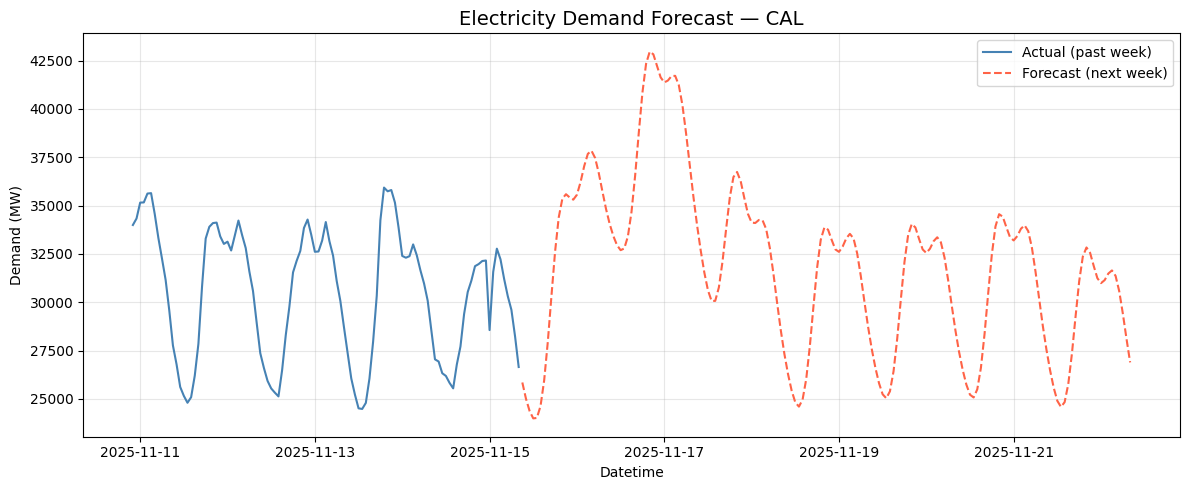

In [8]:
import matplotlib.pyplot as plt
# Plot
region = "CAL"

actual = (
    df[df["region"] == region]
    .drop_duplicates(subset=["datetime"])  # Ensure no duplicate datetime values
    .set_index("datetime")["demand_MW"]
    .asfreq("H")
    .interpolate()
)
forecast = (
    forecast_df[forecast_df["region"] == region]
    .drop_duplicates(subset=["ds"])  # Ensure no duplicate datetime values
    .set_index("ds")["forecast_MW"]
)

plt.figure(figsize=(12,5))
plt.plot(actual[-7*24:], label="Actual (past week)", color="steelblue")
plt.plot(forecast, label="Forecast (next week)", color="tomato", linestyle="--")
plt.title(f"Electricity Demand Forecast — {region}", fontsize=14)
plt.xlabel("Datetime"); plt.ylabel("Demand (MW)")
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()